``` python
from __future__ import division
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

# 1. Download sunspot dataset and upload the same to dataset directory
#    Load the sunspot dataset as an Array
!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()
```

In [1]:
from __future__ import division
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

/home/sukhjinder/anaconda/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/sukhjinder/anaconda/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/sukhjinder/anaconda/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/sukhjinder/anaconda/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/sukhjinder/anaconda/lib/python2.7/site-packages/pandas/core/i

In [10]:
# 1. Download sunspot dataset and upload the same to dataset directory
#    Load the sunspot dataset as an Array
!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'Voltage/Current'])
data_as_frame.head()

Continuing in background, pid 8984.
Output will be written to ‘wget-log.2’.


,Months,Voltage/Current
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


```python
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences. 
    Args:
    -----
            data (pandas.Series): independent variable 
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution
            
    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html
         
    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
  """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation
    
    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies
    
    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) for 
                                                       index, y_i, avg_i in izip(count(), y, avg) 
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}
        
        
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation
    
    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, 
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) 
                                                       for index, y_i, avg_i, rs_i in izip(count(), 
                                                                                           y, avg_list, rolling_std) 
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies. 
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch 
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    
    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
            
    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float, 
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    
    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()
 
 
# 4. Lets play with the functions
x = data_as_frame['Months']
Y = data_as_frame['SunSpots']

# plot the results
plot_results(x, y=Y, window_size=10, title_for_plot="Anomalies in Sun Spots Using Stationary Standard Deviation", text_xlabel="Months", sigma_value=3, text_ylabel="Number of Sun Spots")

# Get details about the data flagged as annomalies
events = explain_anomalies(y=Y, window_size=10, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))
```

In [11]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences. 
    Args:
    -----
        data (pandas.Series): independent variable 
        window_size (int): rolling window size

    Returns:
    --------
        ndarray of linear convolution
            
    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html     
    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation
    
    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, 
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) 
                                                       for index, y_i, avg_i, rs_i in izip(count(), 
                                                                                           y, avg_list, rolling_std) 
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}
              
def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation
    
    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3), 
            'anomalies_dict': 
            collections.OrderedDict([(index, y_i) for index, y_i, avg_i in izip(count(), y, avg_list) 
              if (y_i > avg_i + (sigma * std)) | (y_i < avg_i - (sigma * std))])}

# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, title_for_plot, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies. 
        Supports both moving and stationary standard deviation
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
    """
    fig = plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    fig.suptitle(title_for_plot, fontsize=20)
    
    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
            
    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float, count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    
    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

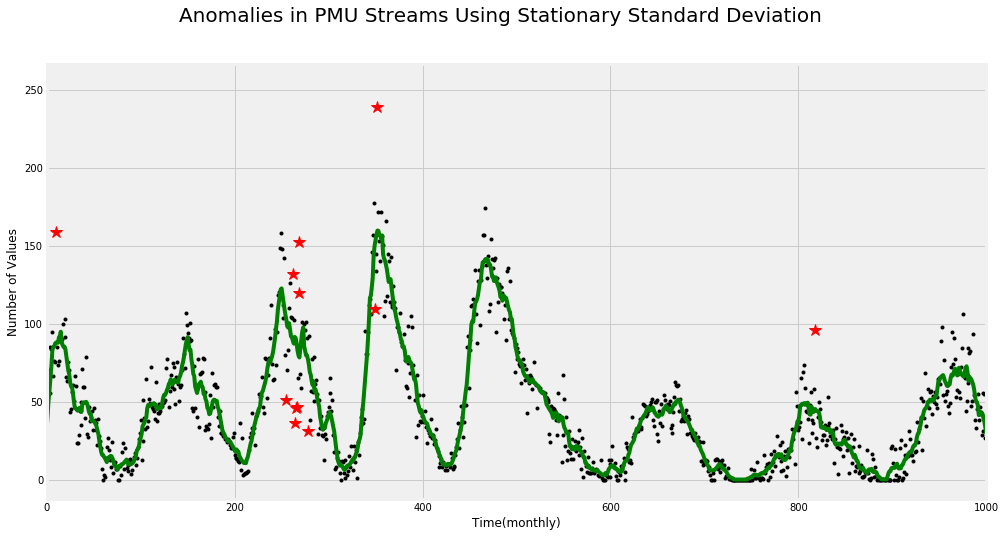

Information about the anomalies model:{'anomalies_dict': OrderedDict([(10, 158.6), (255, 51.0), (262, 132.2), (264, 36.0), (265, 46.2), (266, 46.7), (268, 152.7), (269, 119.5), (278, 31.1), (349, 109.3), (352, 238.9), (818, 96.2), (1055, 206.3), (1056, 188.0), (1087, 131.2), (1088, 132.7), (1172, 107.1), (1182, 52.2), (1184, 160.9), (1185, 180.4), (1456, 176.0), (1464, 88.3), (1735, 129.2), (1882, 107.2), (1890, 103.6), (1893, 17.8), (1897, 108.2), (2023, 154.5), (2045, 111.2), (2171, 108.0), (2274, 165.3), (2380, 201.3), (2389, 86.1), (2390, 94.8), (2391, 189.7), (2398, 95.8), (2401, 182.3), (2494, 201.3), (2497, 130.3), (2503, 158.0), (2505, 253.8), (2527, 199.6), (2760, 166.6), (2789, 90.9), (2800, 82.2), (2809, 51.0), (2879, 179.2), (2885, 196.2), (2899, 200.3), (2917, 161.1), (3005, 137.7), (3018, 170.1)]), 'stationary standard_deviation': 13.342}


In [13]:
x = data_as_frame['Months']
Y = data_as_frame['Voltage/Current']

# plot the results
plot_results(x, y=Y, window_size=10, title_for_plot="Anomalies in PMU Streams Using Stationary Standard Deviation",
             text_xlabel="Time(monthly)", sigma_value=3, text_ylabel="Number of Values")

# Get details about the data flagged as annomalies
events = explain_anomalies(y=Y, window_size=10, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Lets see if the above anomaly detection function could be used for another use-case. For this tutorial lets assume that we generate a random dataset which hypothetically relates to Company A's stock value over a peroid of time. X Axis represents Time in days(since 2013) and Y Axis represents the value of the Stock in dollars($). 

```python
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2*np.asarray(yval)*np.random.normal(size=len(yval))
    
# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state 

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = range(0, size_of_array)
    y_new = [y_i + index**((size_of_array - index)/size_of_array) +  noise()
     for index, y_i in izip(count(), y)]
    return x, pd.Series(y_new)
    
    
# Lets play
x1, y1 = generate_random_dataset()
# Using stationary standard deviation over a continuous sample replicating 
plot_results(x1, y1, window_size=50, title_for_plot="Anomalies in Stock Value Using Stationary Standard", sigma_value=2, text_xlabel="Time (Days)", text_ylabel="Value (US Dollars)")
 
# using rolling standard deviation
plot_results(x1, y1, window_size=50, title_for_plot="Anomalies in Stock Value Using Rolling Standard Deviation Deviation", sigma_value=2, text_xlabel="Time (Days)", text_ylabel="Value (US Dollars)", applying_rolling_std=True)
```

In [8]:
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2*np.asarray(yval)*np.random.normal(size=len(yval))
    
# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state 

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = range(0, size_of_array)
    y_new = [y_i + index**((size_of_array - index)/size_of_array) 
             for index, y_i in izip(count(), y)]
    y_new = y_new + noise(y_new)
    return x, pd.Series(y_new)

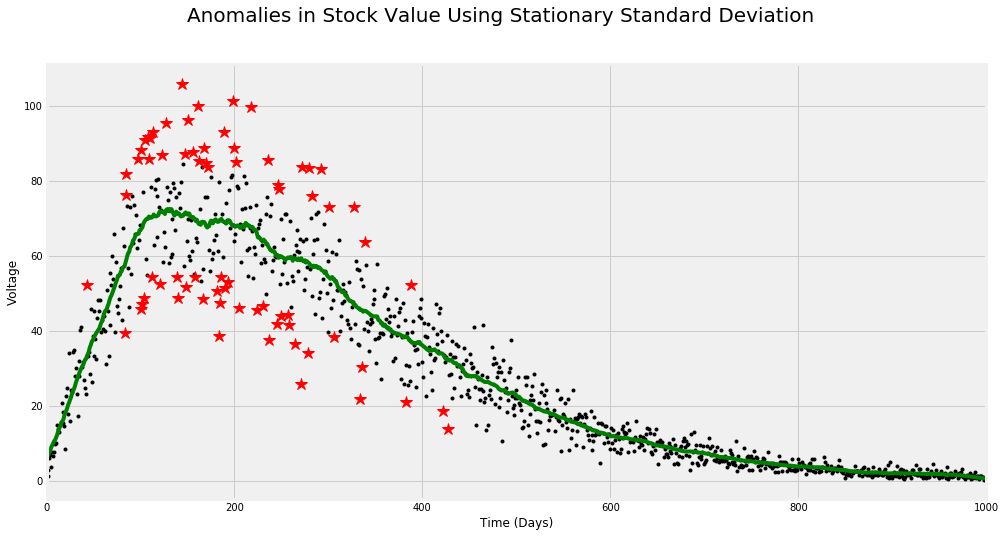

In [14]:
x1, y1 = generate_random_dataset()
plot_results(x1, y1, window_size=50, title_for_plot="Anomalies in Stock Value Using Stationary Standard Deviation", 
             sigma_value=2, text_xlabel="Time (Days)", text_ylabel="Voltage")

AttributeError: 'module' object has no attribute 'rolling_std'

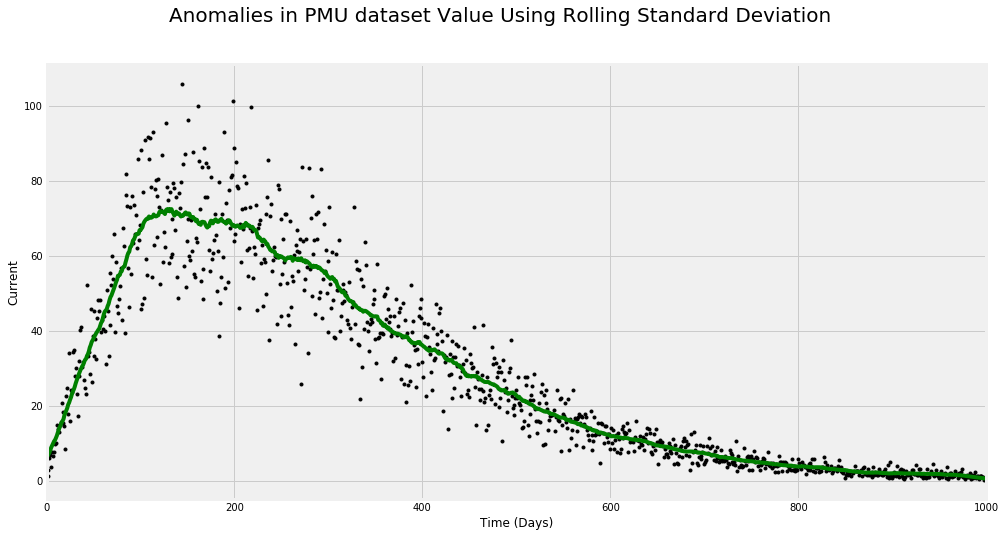

In [16]:
plot_results(x1, y1, window_size=50, title_for_plot="Anomalies in PMU dataset Value Using Rolling Standard Deviation", 
             sigma_value=2, text_xlabel="Time (Days)", text_ylabel="Current", applying_rolling_std=True)